In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
import tensorflow.contrib.slim as slim
import os
import keras

Using TensorFlow backend.


os.environ["CUDA_VISIBLE_DEVICES"] = ''

In [2]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [3]:
mnist_data = keras.datasets.mnist.load_data()

In [4]:
len(mnist_data),len(mnist_data[0])

(2, 2)

In [5]:
mnist_data[0][0].shape, mnist_data[0][1].shape,
mnist_data[1][0].shape, mnist_data[1][1].shape

((10000, 28, 28), (10000,))

In [6]:
x_train = mnist_data[0][0]
y_train = mnist_data[0][1]
x_test = mnist_data[1][0]
y_test = mnist_data[1][1]
x_train.shape, y_train.shape, x_test.shape, y_test.shape, np.max(x_train), np.max(y_train)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), 255, 9)

Text(0.5, 1.0, '5')

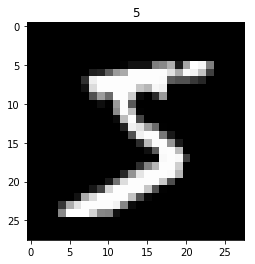

In [7]:
plt.imshow(x_train[0], cmap='gray')
plt.title(y_train[0])

In [8]:
import module

In [9]:
def transformation(x):
    basic_shape = tf.shape(x[:,0,0,0])
    
    s = 0.2
    t = a = 0.2
    sx = tf.random_uniform(basic_shape,1-s, 1+s)
    ax = tf.random_uniform(basic_shape,-a, a)
    tx = tf.random_uniform(basic_shape,-a, a)
    sy = tf.random_uniform(basic_shape,1-s, 1+s)
    ay = tf.random_uniform(basic_shape,-a, a)
    ty = tf.random_uniform(basic_shape,-a, a)
    ones = tf.ones_like(sx)
    zeros = tf.zeros_like(sx)
    #transforms = [sx, ax, tx, ay, sy, ty, 0, 0]
    #transforms = [sx, 0, -tx, 0, 1, -ty, 0, 0] 
    #coef = tf.stack((sx, ax,tx, ay, sy, ty, ones, ones), -1)
    transforms = tf.stack((sx, ax, tx, ay, sy, ty, zeros, zeros), -1)
    return tf.contrib.image.transform(x, transforms)#, interpolation='BILINEAR')

In [10]:
def rotate(x, max_angle):
    max_angle = tf.cast(max_angle, tf.float32)
    degree = tf.random_uniform(tf.shape(x[:,0,0,0]),-max_angle, max_angle)
    #degree = max_angle
    radian = degree * np.pi / 180
    return tf.contrib.image.rotate(x, radian, interpolation='BILINEAR') #NEAREST, BILINEAR

In [11]:
def display_output(display_img):    
    display_img = np.squeeze(display_img, -1)
    display_img = (display_img*255).astype(np.uint8)

    display_m = min(data_m, 10)
    fig, ax=plt.subplots(3, display_m)
    for i in range(display_m):    
        ax[0, i].imshow(display_img[0, i])
        ax[1, i].imshow(display_img[1, i])
        ax[2, i].imshow(display_img[2, i])

In [37]:
is_scratch = False
pkt = 'check1.pkt'

In [38]:
def inference(x):
    with slim.arg_scope([slim.fully_connected, slim.conv2d, slim.conv1d], weights_regularizer=slim.l2_regularizer(0.00001)):
        net = slim.conv2d(x, 32, kernel_size=[7,7], stride=2)
        net = slim.conv2d(net, 64, kernel_size=[3,3])
        net = slim.max_pool2d(net, kernel_size=[2,2])
        net = slim.conv2d(net, 128, kernel_size=[3,3])    
        net_theta = slim.conv2d(net, 6, kernel_size=[3,3])
        theta = net_theta[:, 3, 3]
        theta_original = theta = tf.reshape(theta, [-1, 2, 3])

        if is_scratch:        
            m = tf.shape(x)[0]
            theta_initial = tf.reshape([1,0,0,0,1,0.0], [-1, 2, 3])
            theta = tf.tile(theta_initial, [m,1,1])    

        net = module.spatial_transformer_network(net, theta)
        net_flat = tf.reshape(net, [-1, 7*7*128])
        logits = slim.fully_connected(net_flat, 10)
        return logits, theta_original

In [39]:
learning_rate = 0.01
tf.reset_default_graph()
X = tf.placeholder(tf.uint8, [None, 28, 28])
Y = tf.placeholder(tf.int64, [None])
x_4d = tf.expand_dims(X, -1)
x = tf.cast(x_4d, tf.float32)/255.0

x_rotate = x
if not is_scratch:    
    x_rotate = rotate(x, 10)
    x_rotate = transformation(x)
    
logits, theta = inference(x_rotate)

out =  module.spatial_transformer_network(x_rotate, theta)
theta_initial = tf.reshape([1,0,0,0,1,0.0], [-1, 2, 3])

acc = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(logits, -1, output_type=tf.int64), Y), tf.float32))
loss_regularization = tf.reduce_mean(tf.losses.get_regularization_losses())

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y))
cost +=loss_regularization
cost_initial_theta = tf.reduce_mean(tf.square(theta - theta_initial))    
if is_scratch:    
    cost += cost_initial_theta
    
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
saver = tf.train.Saver()
sess = tf.InteractiveSession()
if is_scratch:
    sess.run(tf.global_variables_initializer())
else:
    saver.restore(sess, pkt)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from check1.pkt


/home/sogangori/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
data_m = 1000
epoch = 1000
for i in range(epoch+1):
    feed = {X:x_train[:data_m],Y:y_train[:data_m]}
    _, _cost, _cost_initial_theta, _acc, out_sample = sess.run([train, cost, cost_initial_theta, acc, out], feed)
    if i%(epoch//10)==0:
        print(i, _acc, _cost,_cost_initial_theta)
        
saver.save(sess, pkt)

0 0.984 0.05549636 0.26741984
100 0.985 0.056971945 0.26299992
200 0.993 0.031527523 0.2630481
300 0.988 0.045598 0.29242095
400 0.993 0.02918312 0.21998607
500 0.985 0.03972446 0.28584126
600 0.992 0.039231755 0.2879576
700 0.991 0.040445734 0.26153263


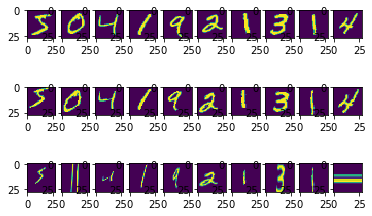

In [47]:
_x, _x_rot, _out = sess.run([x, x_rotate, out], {X:x_train[:data_m]})
display_img = np.stack((_x, _x_rot, _out), axis=0)
display_output(display_img)